# Workaround Example for Cleaning Residual 1/f Noise in NIRSpec IFU Products
--------------------------------------------------------------------------------------------------------
**Latest update**: September 26, 2023.

## Notebook Goals
Produce a cleaned rate file to use as input for the level 2 and 3 pipelines.

## Introduction

This workaround is intended to address a known issue with NIRSpec pipeline products: negative and/or surplus flux in the extracted 1-D spectrum is seen, typically with an irregular wavelength-dependent undulation. The cause of this artifact is correlated noise from low-level detector thermal instabilities, seen as vertical banding in 2-D count rate images, particularly in exposures of the NRS2 detector. While the IRS2 readout mode reduces this effect, it is not completely eliminated.

This workaround uses an external package, developed by Bernard Rauscher, called [NSClean](https://webb.nasa.gov/content/forScientists/publications.html#NSClean), which uses dark areas of the detector to fit a background model to the data in Fourier space.  It requires an input mask to identify all dark areas of the detector. The more thorough and complete this mask is, the better the background fit.  In this notebook, we will use the world coordinate system (WCS) assigned to an intermediate pipeline product to create a mask from the designated non-science areas of the image.  In some cases, this mask may not be complete enough for the best possible noise removal.  If needed, see the NSClean documentation for some suggestions on manually creating a custom mask.

This notebook uses as an example an ERS observation from program 1335: an IFU observation of quasar XID2028 with filter F100LP and grating G140H.

Use this workaround until a residual cleaning algorithm is incorporated into the pipeline.

## Set up

Prior to running this notebook, you will need to install the JWST pipeline and an external package called NSClean, developed by B. Rauscher.

It is recommended to install these packages into a new environment.  For example, using Anaconda:

```
conda create -n nsclean python=3.11
conda activate nsclean
```

Then, the latest pipeline and supporting packages can be installed via pip:

```
pip install jwst matplotlib jupyter pandas
```

If you have not used the pipeline before, you may also need to set some environment variables for retrieving reference data from CRDS, following the pipeline [Quickstart Guide](https://jwst-pipeline.readthedocs.io/en/latest/getting_started/quickstart.html).

Finally, download the latest version of the [NSClean code](https://webb.nasa.gov/content/forScientists/publications.html#NSClean). Unpack the archive and install the contained code with the command below.

For the latest version at time of writing (NSClean v1.9), the archive contains a directory called `nsclean_1.9`. The code may be installed with:

```
pip install -e nsclean_1.9
```

After installing all required packages, restart the jupyter server from the nsclean environment and open this notebook.  For example, from the directory containing this notebook, run:
```
jupyter notebook
```
and select this file.

Running the following cell, containing package imports, should now succeed.

Import necessary packages and print the calibration pipeline version and current context.

In [1]:
import json
import logging
import os
import requests
import warnings

import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip

import jwst
import nsclean
from jwst.datamodels import dqflags
from jwst.pipeline.calwebb_spec2 import Spec2Pipeline
from stpipe import crds_client

# hide all log and warning messages
logging.disable(logging.ERROR)
warnings.simplefilter('ignore', RuntimeWarning)

# print current jwst versions
print(f"JWST calibration pipeline version: {jwst.__version__}")
print(f"Current CRDS context: {crds_client.get_context_used('jwst')}")

JWST calibration pipeline version: 1.12.1
Current CRDS context: jwst_1132.pmap


Define a function to download a named file via the MAST API. The function includes authentication logic, but this example uses public data, so no MAST API token is required.

In [2]:
def get_jwst_file(name, mast_api_token=None):
    """Retrieve a JWST data file from MAST archive."""
    mast_url = "https://mast.stsci.edu/api/v0.1/Download/file"
    params = dict(uri=f"mast:JWST/product/{name}")
    if mast_api_token:
        headers = dict(Authorization=f"token {mast_api_token}")
    else:
        headers = {}
    r = requests.get(mast_url, params=params, headers=headers, stream=True)
    r.raise_for_status()
    with open(name, "wb") as fobj:
        for chunk in r.iter_content(chunk_size=1024000):
            fobj.write(chunk)

Create a list of filenames. Download the data from MAST.

In [3]:
obs_ids = ['jw01335004001_03101_00002']
detectors = [1, 2]

# specify rate and calibrated data products
rate_names = []
cal_names = []
for obs_id in obs_ids:
    for detector in detectors:
        rate_names.append(f'{obs_id}_nrs{detector}_rate.fits')
        cal_names.append(f'{obs_id}_nrs{detector}_cal.fits')

# download all the FITS files
for name in rate_names + cal_names:
    print(f'Downloading {name}')
    get_jwst_file(name)

## Create a mask from a calibrated file

The goal in creating the mask is to identify any pixel that is unilluminated.  That is, the mask must contain True and False values, where True indicates that the pixel is dark, and False indicates that the pixel is illuminated (not dark).

Here, we mark the following detector areas as illuminated, non-dark areas (False):

- pixels designated as science areas for IFU data
- traces from failed-open MSA shutters
- 5-sigma outliers
- any pixel set to NaN in the rate data.

To tune the outlier detection in this mask, try modifying the n_sigma parameter below.  A higher value will identify fewer outliers. A lower value will identify more.

Create and save a mask identifying dark areas of the detector.

In [4]:
# scale parameter for identifying outliers
n_sigma = 5.0

# loop over rate files and cal files together
mask_names = []
for rate_file, cal_file in zip(rate_names, cal_names):
    
    # copy SCI data from rate file
    with fits.open(rate_file) as hdul:
        rate_sci = hdul['SCI'].data.copy()

    # copy DQ data from cal file
    with fits.open(cal_file) as hdul:
        cal_dq = hdul['DQ'].data.copy()

    # initialize mask with everything set to False
    mask = np.full(np.shape(cal_dq), False)

    # find non-science pixels and set them to True
    dark = np.where(cal_dq & dqflags.pixel['NON_SCIENCE'])
    mask[dark] = True

    # find traces of failed open shutters and set them to False
    fail_open = np.where(cal_dq & dqflags.pixel['MSA_FAILED_OPEN'])
    mask[fail_open] = False

    # find NaNs from the rate file
    # set them to 0 in the rate data and False in the mask
    is_nan = np.isnan(rate_sci)
    rate_sci[is_nan] = 0
    mask[is_nan] = False

    # ignore the entire fixed slit area:
    # set it to False in the mask
    mask[922:1116, :] = False

    # keep the reference pixel columns (first and last 4)
    mask[:, :5] = True
    
    # keep one extra column on the right, since it is always empty for NRS1
    mask[:, -5:] = True

    # get clipped stats to flag n-sigma outliers and ignore them in the mask
    _, med, sig = sigma_clipped_stats(rate_sci, mask=~mask, mask_value=0, sigma=5.0)
    outliers = np.where(rate_sci > med + n_sigma * sig)
    mask[outliers] = False

    # save the mask to disk
    outname = rate_file.replace('rate', 'mask')
    fits.writeto(outname, mask.astype(np.uint8), overwrite=True)
    print(f"Saved {outname}") 

    mask_names.append(outname)

Saved jw01335004001_03101_00002_nrs1_mask.fits
Saved jw01335004001_03101_00002_nrs2_mask.fits


## Verify the mask keeps only unilluminated data

Check the mask against the rate data to make sure it keeps only dark areas of the detector.

In this example, note that there are still some remaining illuminated areas, primarily due to transient artifacts like cosmic rays and snowballs.

Plot the rate data with masked areas blocked.

In [5]:
# define a helper function for data plotting

def plot_dark_data(rate_file, mask_file):

    # make a matplotlib figure
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    plt.suptitle(f'Dark areas for {os.path.basename(rate_file)}')

    # open the mask and science data
    with fits.open(mask_file) as hdulist:
        mask = hdulist[0].data

    with fits.open(rate_file) as hdulist:
        sci = hdulist['SCI'].data

    # get data limits from the dark data
    masked_sci = sci.copy()
    masked_sci[mask == 0] = 0
    vmin = np.nanpercentile(masked_sci, 1)
    vmax = np.nanpercentile(masked_sci, 99)

    # plot the science image with limits from the dark data
    sci[np.isnan(sci)] = 0
    ax[0].imshow(sci, origin='lower', vmin=vmin, vmax=vmax)
    ax[0].set_title('Rate data')

    # plot the mask: values are 1 or 0
    ax[1].imshow(mask, origin='lower', vmin=0, vmax=1)
    ax[1].set_title('Mask')

    # plot the dark data with the same limits as the science data
    ax[2].imshow(masked_sci, origin='lower', vmin=vmin, vmax=vmax)
    ax[2].set_title('Dark data')

    fig.tight_layout()

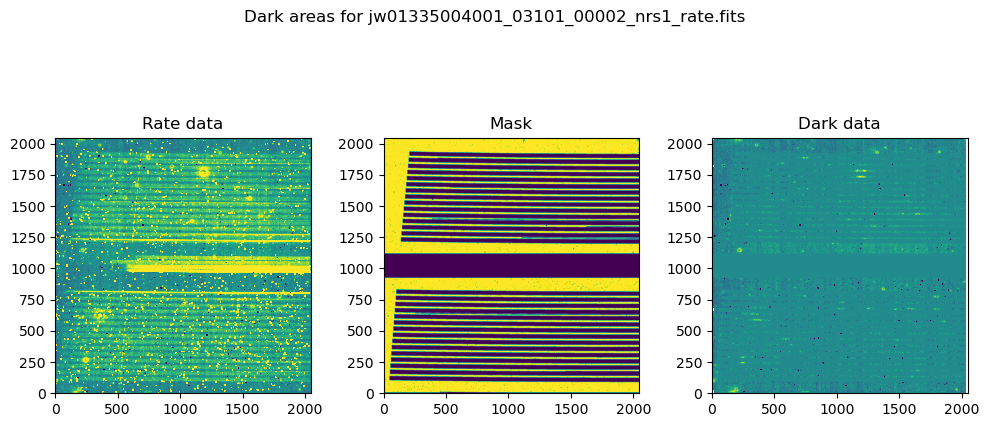

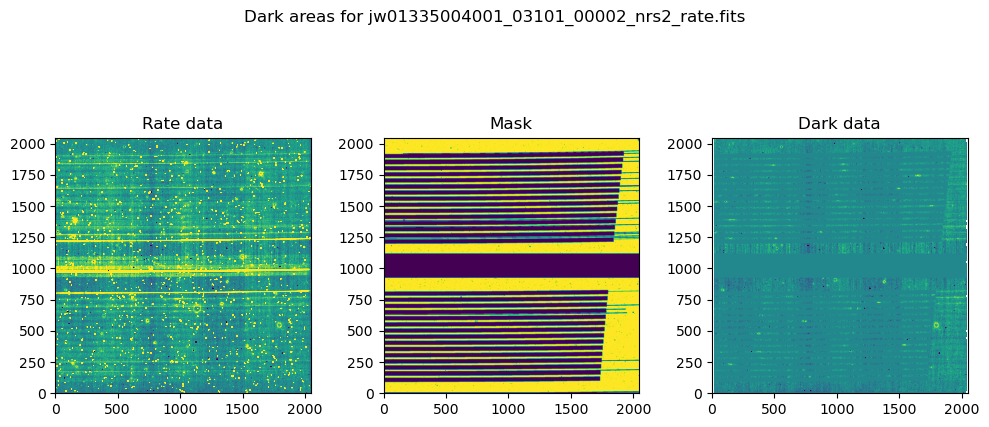

In [6]:
# plot each associated set of rate data and mask file
for rate_file, mask_file in zip(rate_names, mask_names):
    plot_dark_data(rate_file, mask_file)

## Use the mask to clean the rate data

We can now use the NSClean package with the created mask to update the rate data, removing residual noise.

In some situations, the cleaning step may fail to find a fit to the background noise.  In the cell below, the error from the failure is caught and a "Cannot clean" message is shown for the file instead.

This failure may occur if the mask does not contain enough dark data (marked True).  In particular, every column in the mask except for the first and last 4 columns must contain some pixels marked True.  The background fitting procedure considers each column, one at a time, so it will crash if there is no data in a column to fit.

If you're getting error messages from the step below, check that your mask in the image above has at least some True values in every column.

For each file, instantiate the cleaner with the mask, then call the clean function.

In [7]:
# define a helper function to clean each file

def clean(rate_file, mask_file, suffix='rate_cleaned'):
    with fits.open(mask_file) as hdulist:
        mask = hdulist[0].data.astype(bool)

    rate_hdulist = fits.open(rate_file)
    sci = rate_hdulist['SCI'].data
    detector = rate_hdulist[0].header['DETECTOR']

    # set NaN values to zero
    is_nan = np.isnan(sci)
    sci[is_nan] = 0

    # instantiate the cleaner
    cleaner = nsclean.NSClean(detector, mask)

    # clean the data
    try:
        cleaned_sci = cleaner.clean(sci)
    except np.linalg.LinAlgError:
        print(f'Cannot clean {os.path.basename(rate_file)}')
        return None
    
    # restore NaNs
    cleaned_sci[is_nan] = np.nan  # restore NANs

    # save result
    rate_hdulist['SCI'].data = cleaned_sci

    outname = rate_file.replace('rate', suffix)
    rate_hdulist.writeto(outname, overwrite=True)
    rate_hdulist.close()
    print(f'Saved {os.path.basename(outname)}')
    
    return outname

In [8]:
# clean each rate file with its associated mask

cleaned_rate_names = []
for rate_file, mask_file in zip(rate_names, mask_names):
    outname = clean(rate_file, mask_file)
    cleaned_rate_names.append(outname)

Saved jw01335004001_03101_00002_nrs1_rate_cleaned.fits
Saved jw01335004001_03101_00002_nrs2_rate_cleaned.fits


## Check the cleaned data

We can now compare the cleaned data to the original rate file and verify that the noise has been removed.

In many cases, the cleaning process introduces new artifacts to the rate file.  These should be carefully examined and weighed against the benefits of the noise reduction.  If transient artifacts like snowballs are interfering with the cleaning process, it may be beneficial to manually edit the mask to remove these areas from consideration in the background fit. To do so, try varying the outlier detection above, or editing specific pixels in the mask array directly.  Otherwise, see the NSClean documentation for some more suggestions on manual editing.

Note that in the images below, there are scattered values with large relative differences from the original rate file (the relative difference image on the left, below).  These are artifacts of the cleaning process.  

There are also broader low-level residual background effects (the relative difference image on the right, below, with scattered outliers hidden).  These include the background patterns we are trying to remove: the 1/f noise variations in the dispersion direction and the picture frame effect at the top and bottom of the frame.  However, there may also be low-level artifacts introduced by over-fitting the dark data in the cleaning process.

Check both residual images carefully to understand the impact of the cleaning process on your data.

Plot the original and cleaned data, as well as a residual map.

In [9]:
# define a helper function for plotting the cleaned data

def plot_cleaned_data(rate_file, cleaned_file):

    # make a matplotlib figure
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    plt.suptitle(f'Cleaned data for {os.path.basename(rate_file)}')

    # open the original and cleaned data
    with fits.open(rate_file) as hdulist:
        original = hdulist['SCI'].data

    with fits.open(cleaned_file) as hdulist:
        cleaned = hdulist['SCI'].data

    # define image limits from the original data
    vmin = np.nanpercentile(original, 1)
    vmax = np.nanpercentile(original, 99)

    # plot the original data
    original[np.isnan(original)] = 0
    cleaned[np.isnan(cleaned)] = 0
    ax[0, 0].imshow(original, origin='lower', vmin=vmin, vmax=vmax)
    ax[0, 0].set_title('Original rate data')

    # plot the cleaned data with the same image limits
    ax[0, 1].imshow(cleaned, origin='lower', vmin=vmin, vmax=vmax)
    ax[0, 1].set_title('Cleaned rate data')

    # plot the relative difference between the original and cleaned data
    diff = (original - cleaned) / original
    diff[~np.isfinite(diff)] = 0
    vmin = np.nanpercentile(diff, 1)
    vmax = np.nanpercentile(diff, 99)
    ax[1, 0].imshow(diff, origin='lower', vmin=vmin, vmax=vmax)
    ax[1, 0].set_title('Relative difference')

    # plot the relative difference again, this time hiding the outliers so that low-level
    # background changes can be seen
    hide_outliers = np.ma.filled(sigma_clip(diff, masked=True), fill_value=0)
    vmin = np.nanpercentile(hide_outliers, 1)
    vmax = np.nanpercentile(hide_outliers, 99)
    ax[1, 1].imshow(hide_outliers, origin='lower', vmin=vmin, vmax=vmax)
    ax[1, 1].set_title('Relative difference without outliers')

    fig.tight_layout()

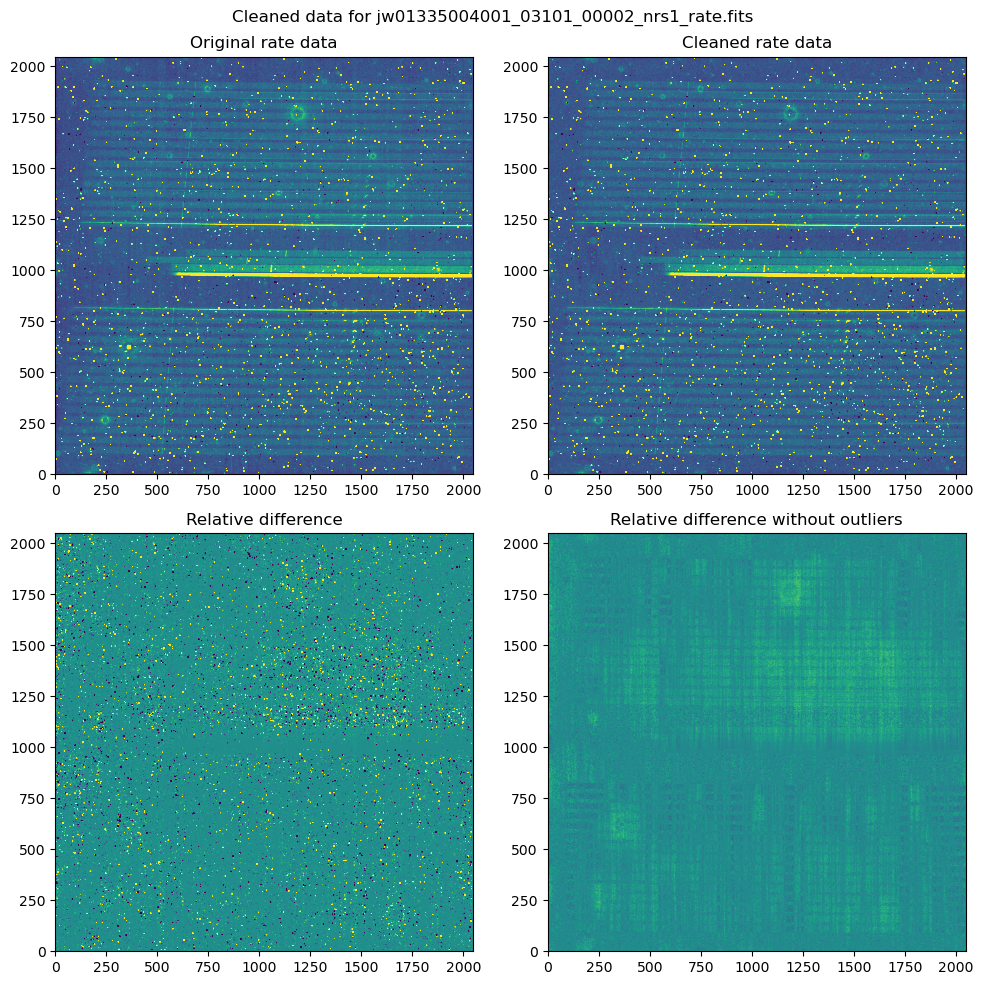

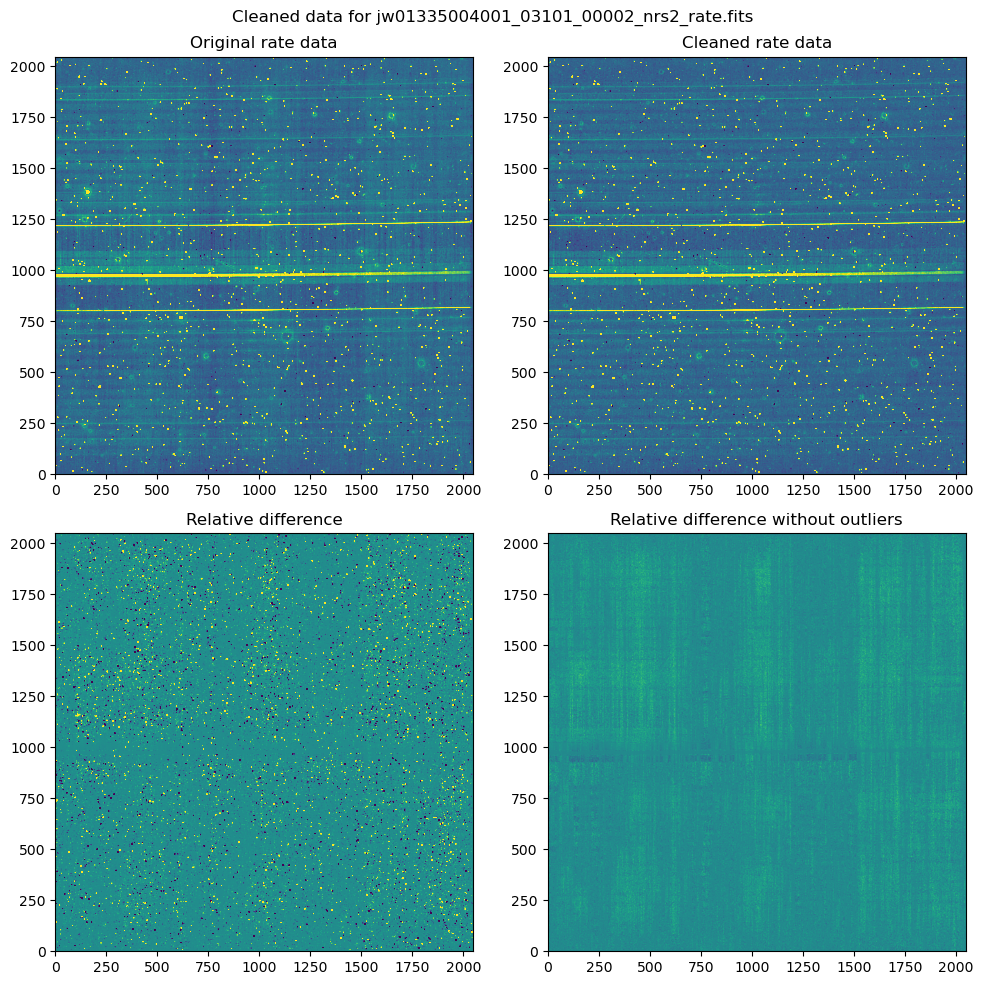

In [10]:
# plot each set of original and cleaned rate files
for rate_file, cleaned_file in zip(rate_names, cleaned_rate_names):
    if cleaned_file is None:
        continue
    plot_cleaned_data(rate_file, cleaned_file)

## Compare extracted spectra

We can now extract a spectrum from the cleaned data and compare it to the spectrum extracted from the original rate file.

Run the spec2 pipeline on both sets of rate data. This will take some time to complete.

In [11]:
x1d_names = []
cleaned_x1d_names = []
for rate_file, cleaned_file in zip(rate_names, cleaned_rate_names):
    if cleaned_file is None:
        continue

    # original rate data
    print(f'Processing {os.path.basename(rate_file)}...')
    Spec2Pipeline.call(rate_file, save_results=True)
    x1d = rate_file.replace('rate', 'x1d')
    x1d_names.append(x1d)
    print(f'Saved {os.path.basename(x1d)}\n')
    
    # cleaned rate data
    print(f'Processing {os.path.basename(cleaned_file)}...')
    Spec2Pipeline.call(cleaned_file, save_results=True)
    x1d = cleaned_file.replace('rate_cleaned', 'rate_cleaned_x1d')
    cleaned_x1d_names.append(x1d)
    print(f'Saved {os.path.basename(x1d)}\n')

Processing jw01335004001_03101_00002_nrs1_rate.fits...
Saved jw01335004001_03101_00002_nrs1_x1d.fits

Processing jw01335004001_03101_00002_nrs1_rate_cleaned.fits...
Saved jw01335004001_03101_00002_nrs1_rate_cleaned_x1d.fits

Processing jw01335004001_03101_00002_nrs2_rate.fits...
Saved jw01335004001_03101_00002_nrs2_x1d.fits

Processing jw01335004001_03101_00002_nrs2_rate_cleaned.fits...
Saved jw01335004001_03101_00002_nrs2_rate_cleaned_x1d.fits



Plot both spectra within a wavelength range of interest.

In [12]:
# define a helper function for plotting original and cleaned spectra together

def plot_spectra(original, cleaned, scale_percent=2.0, wavelength_range=None):
    if wavelength_range is None:
        wavelength_range = {}
    
    # open the data files
    original_hdul = fits.open(original)
    cleaned_hdul = fits.open(cleaned)

    # find the spectral extension (EXTRACT1D)
    for extnum in range(len(original_hdul)):
        hdu = original_hdul[extnum]
        if hdu.name != 'EXTRACT1D':
            continue

        # plot the original and cleaned spectra together
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        plt.suptitle(f'Compare spectra for {os.path.basename(original)}')

        ax[0].plot(hdu.data['WAVELENGTH'], hdu.data['FLUX'],
                   linewidth=1, label=f"original")
        ax[0].plot(hdu.data['WAVELENGTH'], cleaned_hdul[extnum].data['FLUX'], 
                   linewidth=1, label=f"cleaned")
        ax[0].set_xlabel(f"Wavelength ({hdu.header['TUNIT1']})")
        ax[0].set_ylabel(f"Flux ({hdu.header['TUNIT2']})")
        ax[0].set_title("Extracted spectra")
        ax[0].legend()

        # plot the absolute difference between the spectra
        diff = (cleaned_hdul[extnum].data['FLUX'] - hdu.data['FLUX'])
        ax[1].plot(hdu.data['WAVELENGTH'], diff, linewidth=1)
        ax[1].set_xlabel(f"Wavelength ({hdu.header['TUNIT1']})")
        ax[1].set_ylabel(f"Difference in flux ({hdu.header['TUNIT2']})")
        ax[1].set_title("Difference after cleaning")

        # set y ranges
        all_flux = [hdu.data['FLUX'], cleaned_hdul[extnum].data['FLUX']]
        y_range = [np.nanpercentile(all_flux, scale_percent), 
                   np.nanpercentile(all_flux, 100 - scale_percent)]
        ax[0].set_ylim(y_range)
        ax[1].set_ylim([np.nanpercentile(diff, scale_percent), 
                        np.nanpercentile(diff, 100 - scale_percent)])

        # set the x range if needed
        for key in wavelength_range:
            if key in original and wavelength_range[key] is not None:
                ax[0].set_xlim(wavelength_range[key])
                ax[1].set_xlim(wavelength_range[key])
        
        fig.tight_layout()
    
    original_hdul.close()
    cleaned_hdul.close()

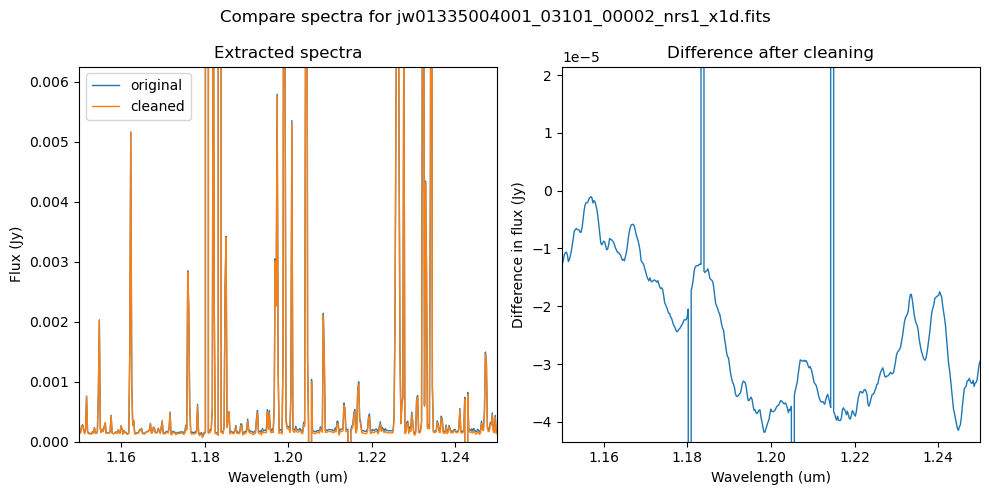

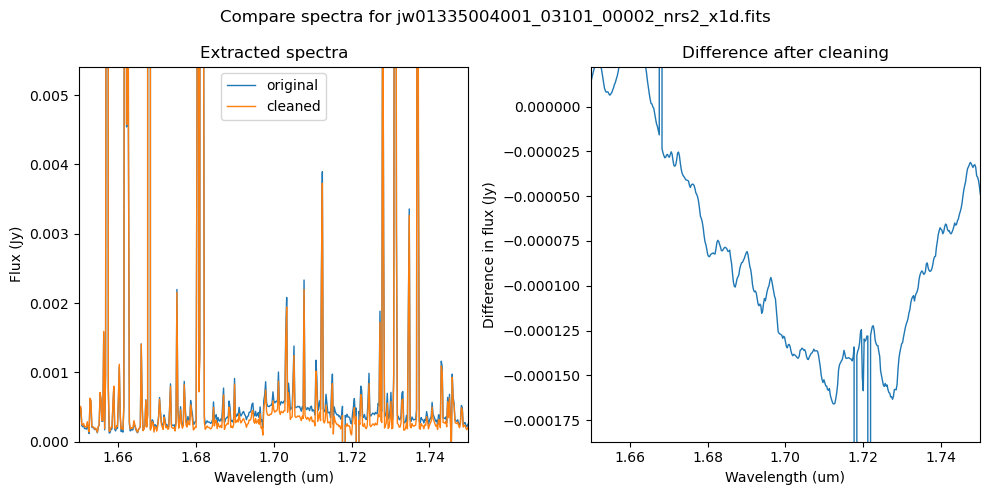

In [13]:
# plot the spectra near a wavelength of interest
wavelength_range = {'nrs1': [1.15, 1.25],
                    'nrs2': [1.65, 1.75]}
for original, cleaned in zip(x1d_names, cleaned_x1d_names):
    plot_spectra(original, cleaned, scale_percent=2, wavelength_range=wavelength_range)

Note that in the portion of the spectrum near 1.2um for NRS1 and 1.7um for NRS2, the excess flux due to 1/f noise is reduced.

Note also that there are several spikes in the difference between the cleaned and original spectra.  These correspond to the scattered artifacts introduced by the cleaning process, above.

The output from the cleaning algorithm is now ready for further processing.  The cal files produced by the above Spec2 pipeline run may be used as input to the Spec3 pipeline, for generating final combined spectral cubes and extracted spectra.

## Alternate masking algorithm

For some data sets, masking the entire science region may excessively mask dark areas of the detector that could be used to improve the background fit.  Excessive masking can introduce some high frequency noise in the cleaning process that appears as vertical striping over the spectral traces.  See the fixed slit region near the center of the detector (x=1000, y=1000) for an example of what this looks like: since this region is completely masked, some residual artifacts are introduced.  This is acceptable for this data set, since we do not extract spectra from this region.

Also, for some data sets, there may be several illuminated regions of the detector that are not masked by the IFU slice bounding boxes.  This may include transient artifacts like cosmic rays or glow from saturated sources.

In some cases, it may be beneficial to build the mask with an alternate algorithm.  Here, we do not use the bounding boxes and instead iteratively mask any data more than 1 sigma above the background.  For bright sources, this might leave more dark data between the spectral traces and may improve the background fit. 

Note, however, that excessive cleaning may impact the continuum level for the spectrum, if too much or too little illuminated data is included in the mask. Again, the generated mask and output spectra should be carefully examined to weigh the benefits of cleaning against the impact on the spectra.

To tune the illumination detection in this mask, try modifying the sigma_limit parameter below. A higher value will identify less illumination. A lower value will identify more.

Create a new mask, clean the data, and re-extract a spectrum.

Saved jw01335004001_03101_00002_nrs1_mask_outliers.fits
Saved jw01335004001_03101_00002_nrs2_mask_outliers.fits


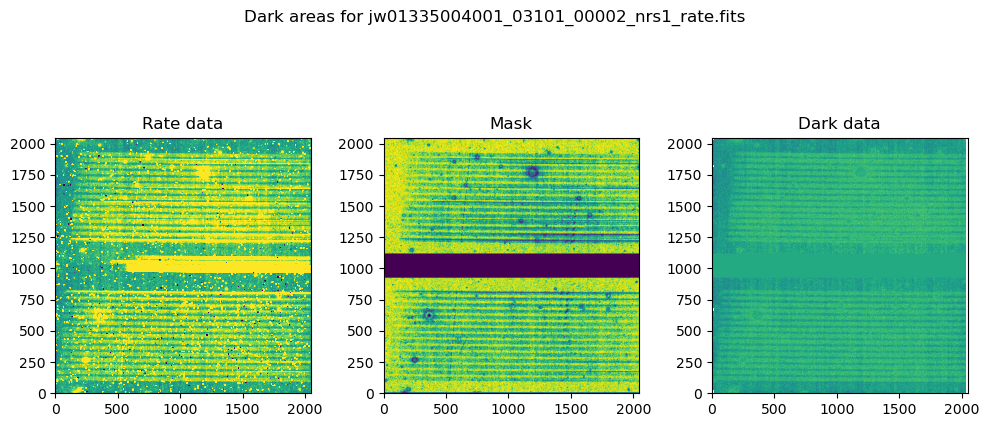

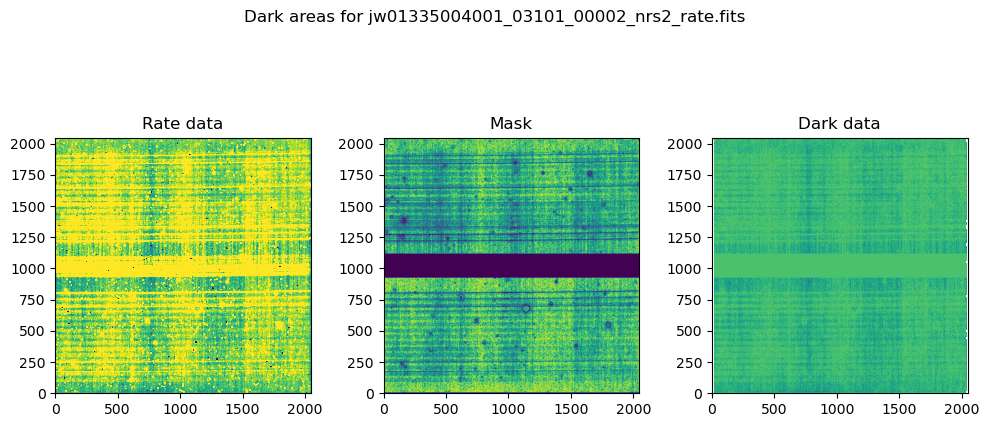

In [14]:
# make a new mask

# iterative sigma clipping limit
sigma_limit = 1.0

outlier_mask_names = []
for rate_file in rate_names:
    # copy SCI data from rate file
    with fits.open(rate_file) as hdul:
        rate_sci = hdul['SCI'].data.copy()

    # initialize mask with everything set to True
    mask = np.full(np.shape(rate_sci), True)
    
    # find NaNs from the rate file
    # set them to 0 in the rate data and False in the mask
    is_nan = np.isnan(rate_sci)
    rate_sci[is_nan] = 0
    mask[is_nan] = False

    # ignore the entire fixed slit area:
    # set it to False in the mask
    mask[922:1116, :] = False

    # keep the left and right reference pixel columns
    mask[:, :5] = True
    mask[:, -5:] = True

    # flag all data n-sigma over the background level
    outliers = sigma_clip(rate_sci, masked=True, sigma_upper=sigma_limit).mask
    mask[outliers] = False

    # save the mask to disk
    outname = rate_file.replace('rate', 'mask_outliers')
    fits.writeto(outname, mask.astype(np.uint8), overwrite=True)
    print(f"Saved {outname}") 

    outlier_mask_names.append(outname)

    # plot the mask and the remaining dark data
    plot_dark_data(rate_file, outname)

Saved jw01335004001_03101_00002_nrs1_rate_outlier_cleaned.fits
Saved jw01335004001_03101_00002_nrs2_rate_outlier_cleaned.fits


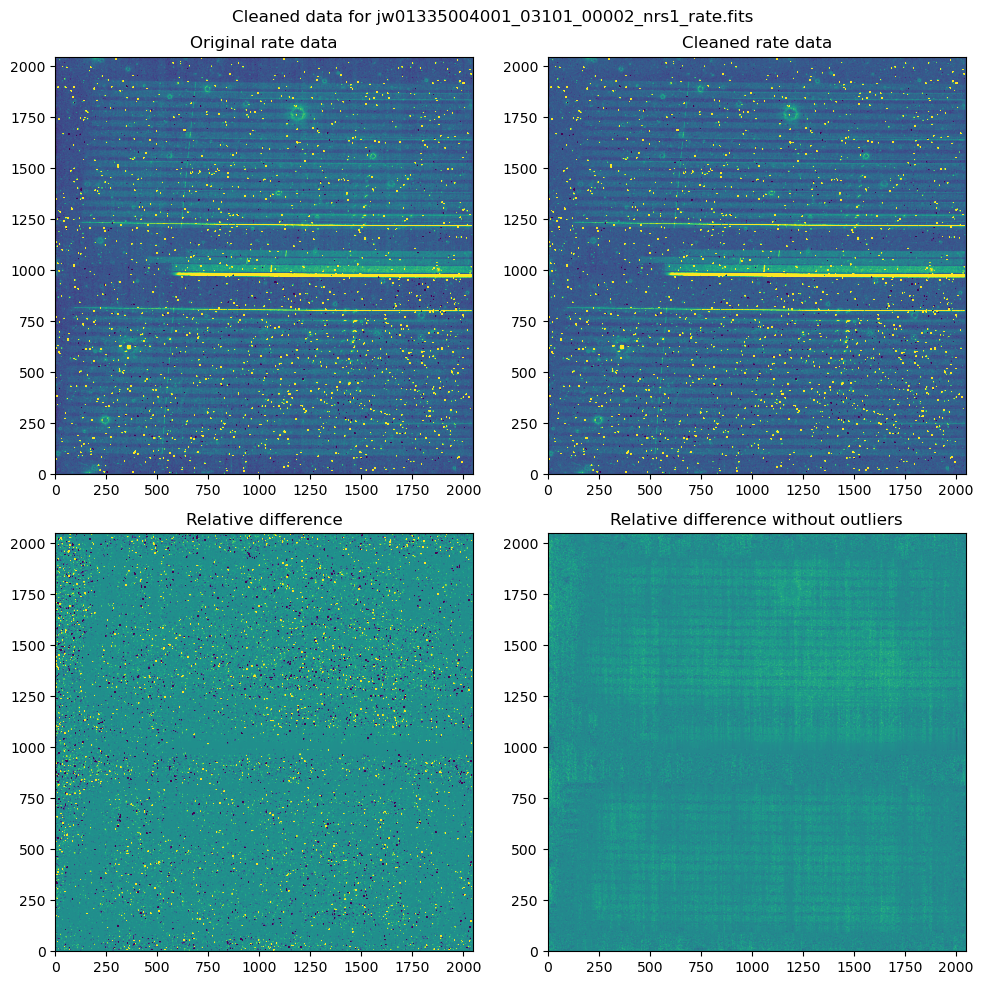

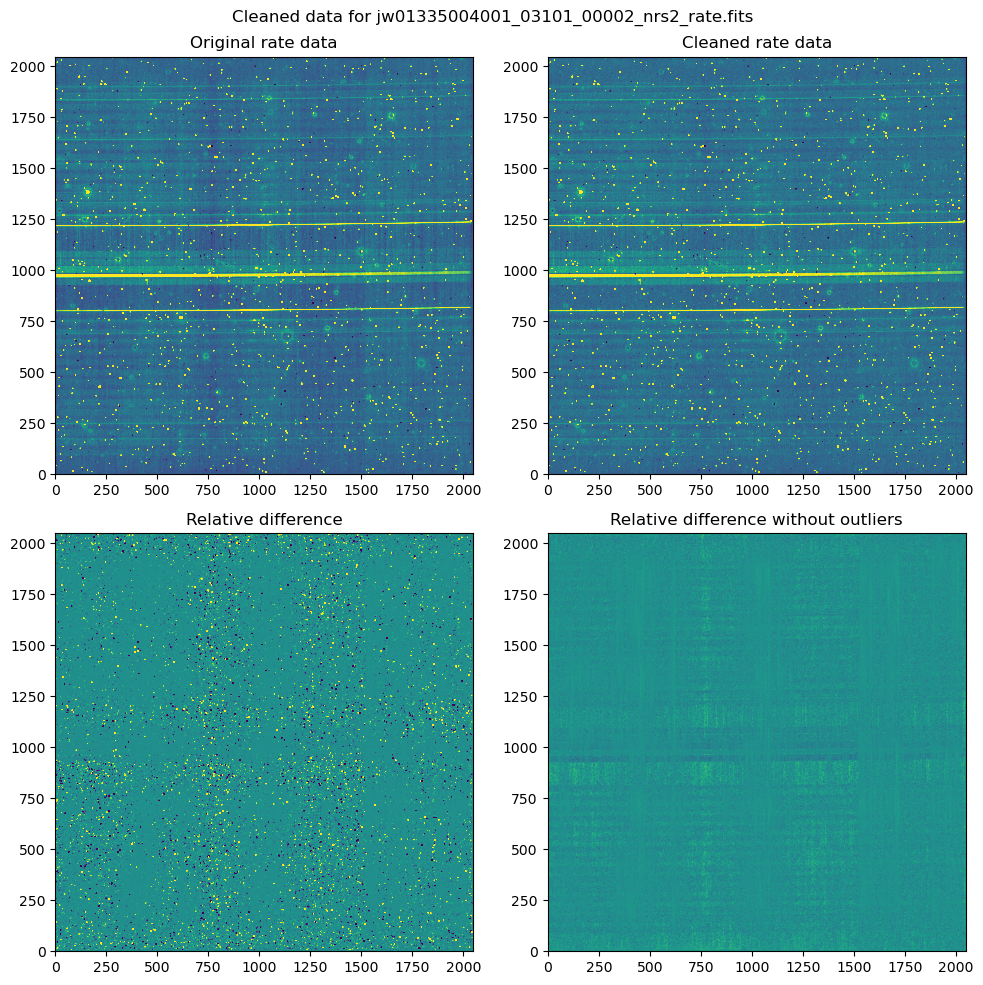

In [15]:
# clean the rate files with the new mask
outlier_cleaned_rate_names = []
for rate_file, mask_file in zip(rate_names, outlier_mask_names):
    outname = clean(rate_file, mask_file, suffix='rate_outlier_cleaned')
    outlier_cleaned_rate_names.append(outname)
    if outname is None:
        continue

    plot_cleaned_data(rate_file, outname)

In [16]:
# extract spectra from the new files
outlier_cleaned_x1d_names = []
for cleaned_file in outlier_cleaned_rate_names:
    if cleaned_file is None:
        continue
        
    # process cleaned rate data
    print(f'Processing {os.path.basename(cleaned_file)}...')
    Spec2Pipeline.call(cleaned_file, save_results=True)
    x1d = cleaned_file.replace('rate_outlier_cleaned', 'rate_outlier_cleaned_x1d')
    outlier_cleaned_x1d_names.append(x1d)
    print(f'Saved {os.path.basename(x1d)}\n')
    assert os.path.isfile(x1d)

Processing jw01335004001_03101_00002_nrs1_rate_outlier_cleaned.fits...
Saved jw01335004001_03101_00002_nrs1_rate_outlier_cleaned_x1d.fits

Processing jw01335004001_03101_00002_nrs2_rate_outlier_cleaned.fits...
Saved jw01335004001_03101_00002_nrs2_rate_outlier_cleaned_x1d.fits



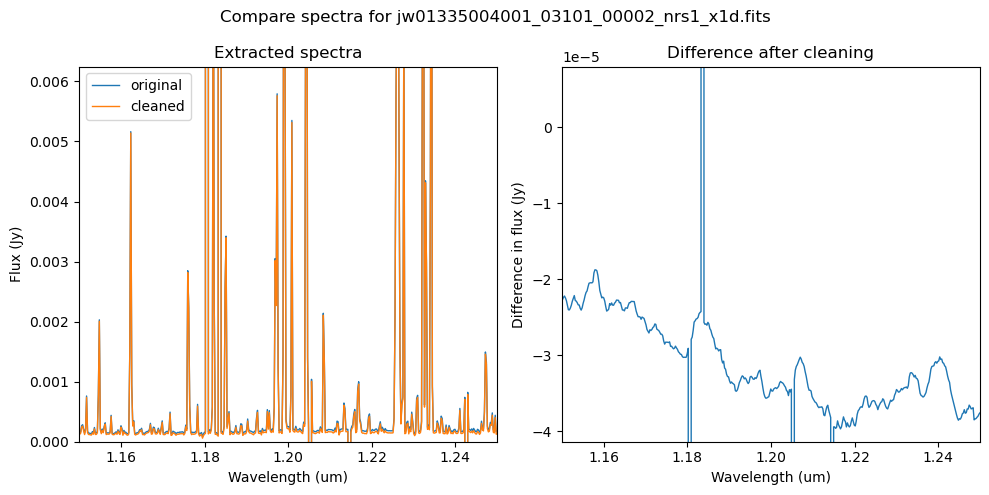

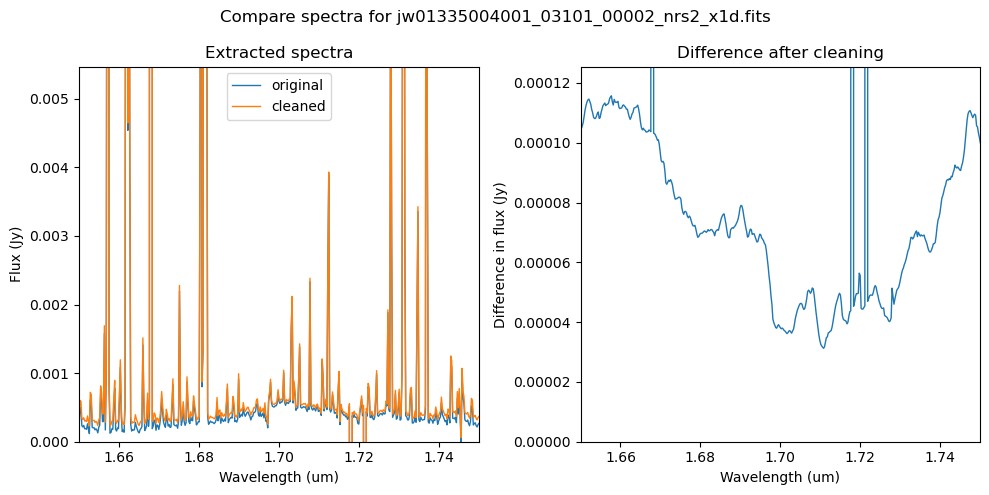

In [17]:
for original, cleaned in zip(x1d_names, outlier_cleaned_x1d_names):
    plot_spectra(original, cleaned, wavelength_range=wavelength_range, scale_percent=2)

Note that cleaning with this mask still removes some of the wavelength-dependent variations, but leaves some residual background variation in NRS2.  Also note that the overall continuum level for the spectrum has changed, especially for NRS2.  In this case, the original algorithm, blocking the entire science region for each IFU slice, is preferable to making the mask via sigma clipping.